In [157]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)

In [158]:
df=pd.read_csv('train.csv')



In [159]:
count=df.isna().sum()
count=count.loc[(lambda x :x>0)].apply(lambda x:np.round(x/df.shape[0]*100,2))


    

In [160]:
df=df.drop(columns=['Alley','PoolQC','Fence','MiscFeature'])
df=df.dropna(subset=['MasVnrArea','Electrical'])


In [161]:
count=df.isna().sum()
count=count.loc[(lambda x :x>0)].apply(lambda x:np.round(x/df.shape[0]*100,2))

In [162]:
num=[]
for col in list(count.index):
    if df[col].dtype!='object':
        num.append(col)

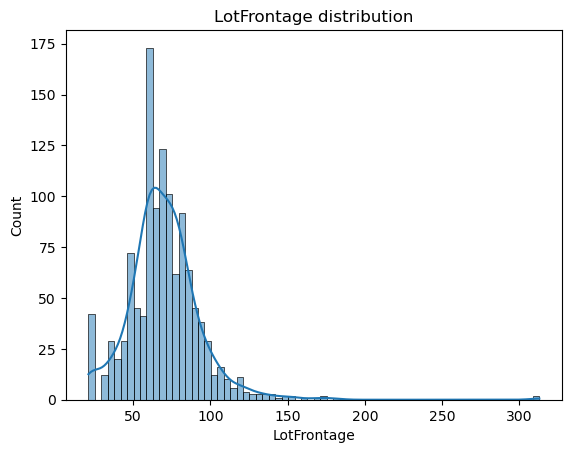

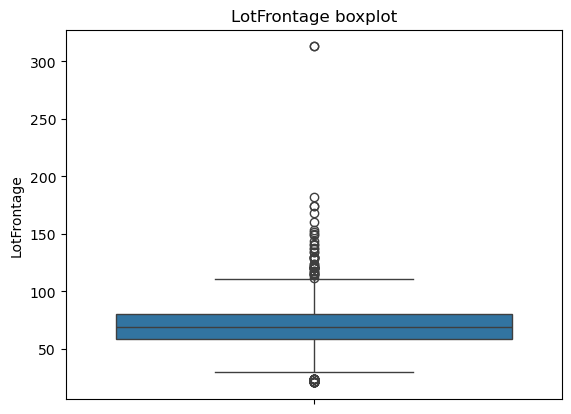

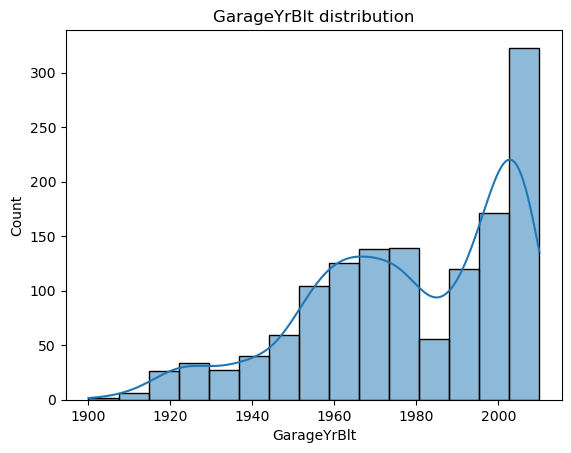

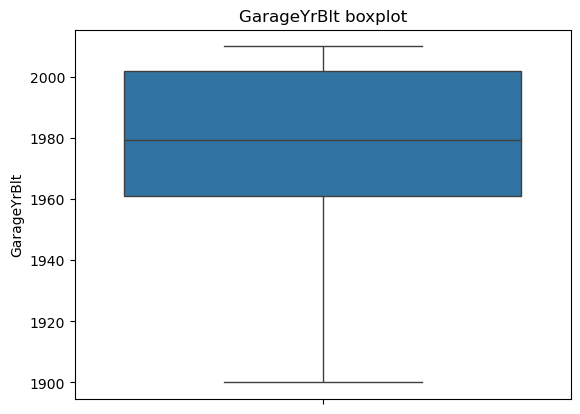

In [163]:
for n in num:
    sns.histplot(df[n],kde=True)
    plt.title(f'{n} distribution')
    plt.show()
    sns.boxplot(df[n])
    plt.title(f'{n} boxplot')
    plt.show()

In [164]:
from sklearn.impute import SimpleImputer
mean_impute=SimpleImputer(strategy='mean')
median_impute=SimpleImputer(strategy='median')
df['LotFrontage']=median_impute.fit_transform(df[[num[0]]])
df[num[1]]=mean_impute.fit_transform(df[[num[1]]])

In [165]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
cat_cols=df.select_dtypes(include=['object']).columns
num_cols=df.select_dtypes(exclude=['object']).columns
preprocessor=ColumnTransformer(transformers=[
    ('cat',OneHotEncoder(sparse_output=False),cat_cols),
    ('num','passthrough',num_cols)
])
df_encoded=preprocessor.fit_transform(df)
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_feature_names = np.concatenate([ohe_feature_names, num_cols])
df_encoded = pd.DataFrame(df_encoded, columns=all_feature_names, index=df.index)

In [166]:
# LootFrontage 17% missing values we are going to use KNN simple Imputer
from sklearn.impute import KNNImputer

knnimputer=KNNImputer(n_neighbors=23)
df_imp=knnimputer.fit_transform(df_encoded)
df_encoded=pd.DataFrame(df_imp,columns=df_encoded.columns,index=df_encoded.index)